In [249]:
import tensorflow as tf
import librosa
import numpy as np
import os

In [250]:
model = tf.keras.models.load_model("mono_all_5x.h5")

In [251]:
# === CQT Configuration ===
hop_length_sec = 0.01               # 10 ms
fmin = librosa.note_to_hz('A0')     # Start at A0 (piano)
bins_per_octave = 36                # 3 bins per semitone
n_bins = 267                        # Covers A0 to C8
sr = 22050
hop_length = int(hop_length_sec * sr)
# hop_length

In [280]:
# audio_path = r'note_silence\audio'
# audio_path = r'note_silence_combined'


# audio = os.path.join(audio_path, f'C4_alternate_{dura}s.mp3')
# audio = os.path.join(audio_path, 'C4_durations_combined.mp3')
audio = r'gen_audio\Mary.mp3'
y, _ = librosa.load(audio, sr=sr)

C = librosa.cqt(
    y, sr=sr,
    hop_length=hop_length,
    fmin=fmin,
    n_bins=n_bins,
    bins_per_octave=bins_per_octave
)
C_dB = librosa.amplitude_to_db(np.abs(C), ref=np.max)


In [281]:
X_test = C_dB[:, :]
X_test.shape

(267, 978)

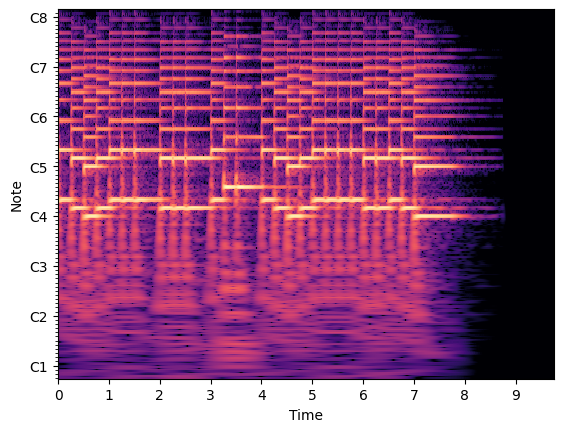

In [282]:
librosa.display.specshow(X_test[:,:], sr=sr, hop_length=hop_length,
                            x_axis='time', y_axis='cqt_note',
                            fmin=fmin, bins_per_octave=bins_per_octave,
                            cmap='magma')


In [283]:

def create_sliding_windows(cqt, window_size=9, stride=1):
    pad = window_size // 2  # pad equally on both sides
    cqt_padded = np.pad(cqt, ((0, 0), (pad, pad)), mode='edge')  # pad only time axis
    num_time_bins = cqt.shape[1]

    windows = np.array([
        cqt_padded[:, i:i + window_size]  # shape: (267, window_size)
        for i in range(0, num_time_bins, stride)
    ])
    return windows[..., np.newaxis]  # shape: (1000, 267, 9, 1)


X_input = create_sliding_windows(X_test, window_size=9, stride=1)  # (num_windows, 267, 9, 1)
print("Sliding Window X_input Shape:", X_input.shape)

Sliding Window X_input Shape: (978, 267, 9, 1)


In [284]:
predict = model.predict(X_input[:])
print("Output size : ", predict.shape)

31/31 [==============================] - 0s 4ms/step
Output size :  (978, 128)


In [285]:
import pretty_midi
import numpy as np

def model_output_to_midi(output, sr=22050, hop_length=220, threshold=0.5, filename="model_output.mid"):

    fs = sr / hop_length  # frames per second
    time_per_frame = 1.0 / fs

    # Threshold the output if it's not binary already
    binary_roll = (output > threshold).astype(np.uint8)

    # Create MIDI object and instrument
    midi_out = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=0)  # Acoustic Grand Piano

    # Loop over each pitch (0 to 127)
    for pitch in range(128):
        active = binary_roll[:, pitch]
        changes = np.diff(np.pad(active, (1, 1)))
        onsets = np.where(changes == 1)[0]
        offsets = np.where(changes == 255)[0]

        for start_idx, end_idx in zip(onsets, offsets):
            start = start_idx * time_per_frame
            end = end_idx * time_per_frame
            note = pretty_midi.Note(velocity=100, pitch=pitch, start=start, end=end)
            instrument.notes.append(note)
    midi_out.instruments.append(instrument)
    midi_out.write(filename)
    print(midi_out)
    print(f"MIDI file saved as: {filename}")


In [286]:
save_file = "Mary_out.mid"
model_output_to_midi(predict,sr=sr, hop_length=hop_length, filename=save_file)

MIDI file saved as: Mary_out.mid


In [287]:
midi_data = pretty_midi.PrettyMIDI(save_file)
fs_pianoroll = sr / hop_length  # Frame rate to match CQT
piano_roll = midi_data.get_piano_roll(fs=fs_pianoroll)

In [288]:
print("Audio duration (sec):", len(y) / sr)
print("CQT frames:", C_dB.shape[1])
print("Piano roll frames:", piano_roll.shape[1])
print("Frame duration (sec):", hop_length / sr)


Audio duration (sec): 9.75047619047619
CQT frames: 978
Piano roll frames: 977
Frame duration (sec): 0.009977324263038548


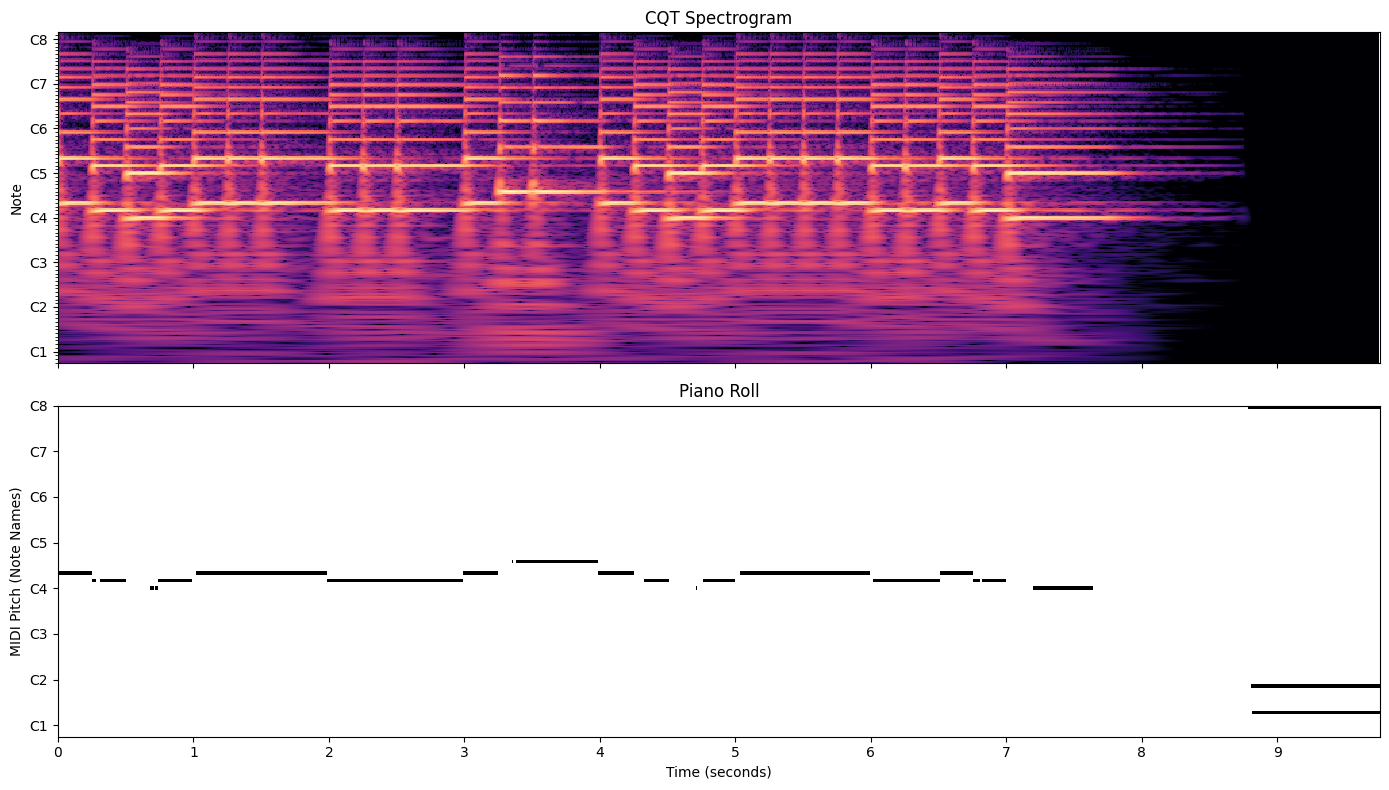

In [289]:
import matplotlib.pyplot as plt
pitch_min = 21    # A0
pitch_max = 108   # C8
duration_sec = X_test.shape[1] * hop_length / sr

# Plot setup
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# === Plot CQT ===
librosa.display.specshow(
    X_test,
    sr=sr,
    hop_length=hop_length,
    x_axis='s',                  # <--- force time in seconds
    y_axis='cqt_note',
    fmin=fmin,
    bins_per_octave=bins_per_octave,
    cmap='magma',
    ax=axs[0]
)
axs[0].set_title("CQT Spectrogram")
axs[0].label_outer()  # hide x-label

# === Plot Piano Roll ===
pitch_min = 21
pitch_max = 108

axs[1].imshow(
    piano_roll[pitch_min:pitch_max+1,:],
    aspect='auto',
    origin='lower',
    cmap='gray_r',
    interpolation='nearest',
    extent=[0, duration_sec, pitch_min, pitch_max]
)

axs[1].set_xlabel('Time (seconds)')
axs[1].set_ylabel('MIDI Pitch (Note Names)')
axs[1].set_title('Piano Roll')
axs[1].set_ylim(pitch_min, pitch_max)

# Label only natural C notes
c_notes = [n for n in range(pitch_min, pitch_max+1)
           if pretty_midi.note_number_to_name(n).startswith('C') and '#' not in pretty_midi.note_number_to_name(n)]
axs[1].set_yticks(c_notes)
axs[1].set_yticklabels([pretty_midi.note_number_to_name(n) for n in c_notes])

plt.tight_layout()
plt.show()


In [262]:
import matplotlib.patches as mpatches

def get_binary_roll(pr, threshold=0):
    return (pr > threshold).astype(np.int8)

def classify_notes(gt, pred):
    TP = (gt == 1) & (pred == 1)
    FN = (gt == 1) & (pred == 0)
    FP = (gt == 0) & (pred == 1)
    return TP, FN, FP

def align_pianorolls(pr1, pr2):
    max_len = max(pr1.shape[1], pr2.shape[1])
    pr1_aligned = np.pad(pr1, ((0, 0), (0, max_len - pr1.shape[1])), mode='constant')
    pr2_aligned = np.pad(pr2, ((0, 0), (0, max_len - pr2.shape[1])), mode='constant')
    return pr1_aligned, pr2_aligned

def compute_difference(pr1, pr2):
    return np.abs(pr1 - pr2)  # absolute difference

In [290]:
import pretty_midi

# dura = '1_0000'
reff = r'output\fixed.mid'

estt = save_file

# midi_1 = r'dataset/full.mid'
midi_data_1 = pretty_midi.PrettyMIDI(reff)
midi_data_2 = pretty_midi.PrettyMIDI(estt)

fs_pianoroll = sr / hop_length  # Frame rate to match CQT
piano_roll_1 = midi_data_1.get_piano_roll(fs=fs_pianoroll)
piano_roll_2 = midi_data_2.get_piano_roll(fs=fs_pianoroll)

m1, m2 = align_pianorolls(piano_roll_1, piano_roll_2)
diff = compute_difference(m1, m2)

fs = sr / hop_length  # your sampling rate/hop setup
pr1 = midi_data_1.get_piano_roll(fs=fs)
pr2 = midi_data_2.get_piano_roll(fs=fs)

pr1_bin = get_binary_roll(pr1)
pr2_bin = get_binary_roll(pr2)

m1_bin, m2_bin = align_pianorolls(pr1_bin, pr2_bin)
TP, FN, FP = classify_notes(m1_bin, m2_bin)



In [291]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

def plot_piano_rolls(pr1, pr2, fs=100, title="Piano Roll Comparison"):
    time_len = pr1.shape[1]
    xticks = np.arange(0, time_len, fs)
    xtick_labels = [f"{x/fs:.1f}" for x in xticks]
    yticks = np.arange(0, 128, 12)
    ylabels = [f'C{i}' for i in range(11)]

    fig, axs = plt.subplots(2, 1, figsize=(24, 6), sharex=True)

    axs[0].imshow(pr1, aspect='auto', origin='lower', cmap='Greens')
    axs[0].set_yticks(yticks)
    axs[0].set_yticklabels(ylabels)
    axs[0].set_title("Reference MIDI")
    axs[0].set_ylabel("MIDI Note")
    axs[0].set_xticks(xticks)
    axs[0].set_xticklabels(xtick_labels)
    # axs[0].set_ylim(55, 65)


    axs[1].imshow(pr2, aspect='auto', origin='lower', cmap='Blues')
    axs[1].set_yticks(yticks)
    axs[1].set_yticklabels(ylabels)
    axs[1].set_title("Estimated MIDI")
    axs[1].set_ylabel("MIDI Note")
    axs[1].set_xlabel("Time (s)")
    axs[1].set_xticks(xticks)
    axs[1].set_xticklabels(xtick_labels)
    # axs[1].set_ylim(55,65)

    fig.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

def plot_notewise_eval(TP, FN, FP, fs=1000, title="Note-wise Evaluation (TP, FN, FP)"):
    time_len = TP.shape[1]
    xticks = np.arange(0, time_len, fs)
    xtick_labels = [f"{x/fs:.1f}" for x in xticks]
    yticks = np.arange(0, 128, 12)
    ylabels = [f'C{i}' for i in range(11)]

    # Set wider figure and taller height
    fig, ax = plt.subplots(figsize=(24, 4))  # wider and taller
    extent = [0, time_len / fs, 0, 128]

    # Background
    ax.imshow(np.ones_like(TP), cmap="gray_r", origin="lower", extent=extent, aspect='auto')

    # Rectangles
    for matrix, color in zip([TP, FN, FP], ['blue', 'limegreen', 'red']):
        y, x = np.where(matrix)
        for xi, yi in zip(x, y):
            rect = mpatches.Rectangle((xi / fs, yi), 1 / fs, 1, color=color, linewidth=0)
            ax.add_patch(rect)

    # Axis settings
    ax.set_yticks(yticks)
    ax.set_yticklabels(ylabels)
    ax.set_xticks(xticks / fs)
    ax.set_xticklabels(xtick_labels)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("MIDI Note")
    # ax.set_ylim(55, 65)
    ax.set_xlim(0, time_len / fs)
    ax.set_title(title)

    # Legend
    patches = [
        mpatches.Patch(color='blue', label='TP'),
        mpatches.Patch(color='limegreen', label='FN'),
        mpatches.Patch(color='red', label='FP')
    ]
    ax.legend(handles=patches, loc='upper left')

    plt.tight_layout()
    plt.show()



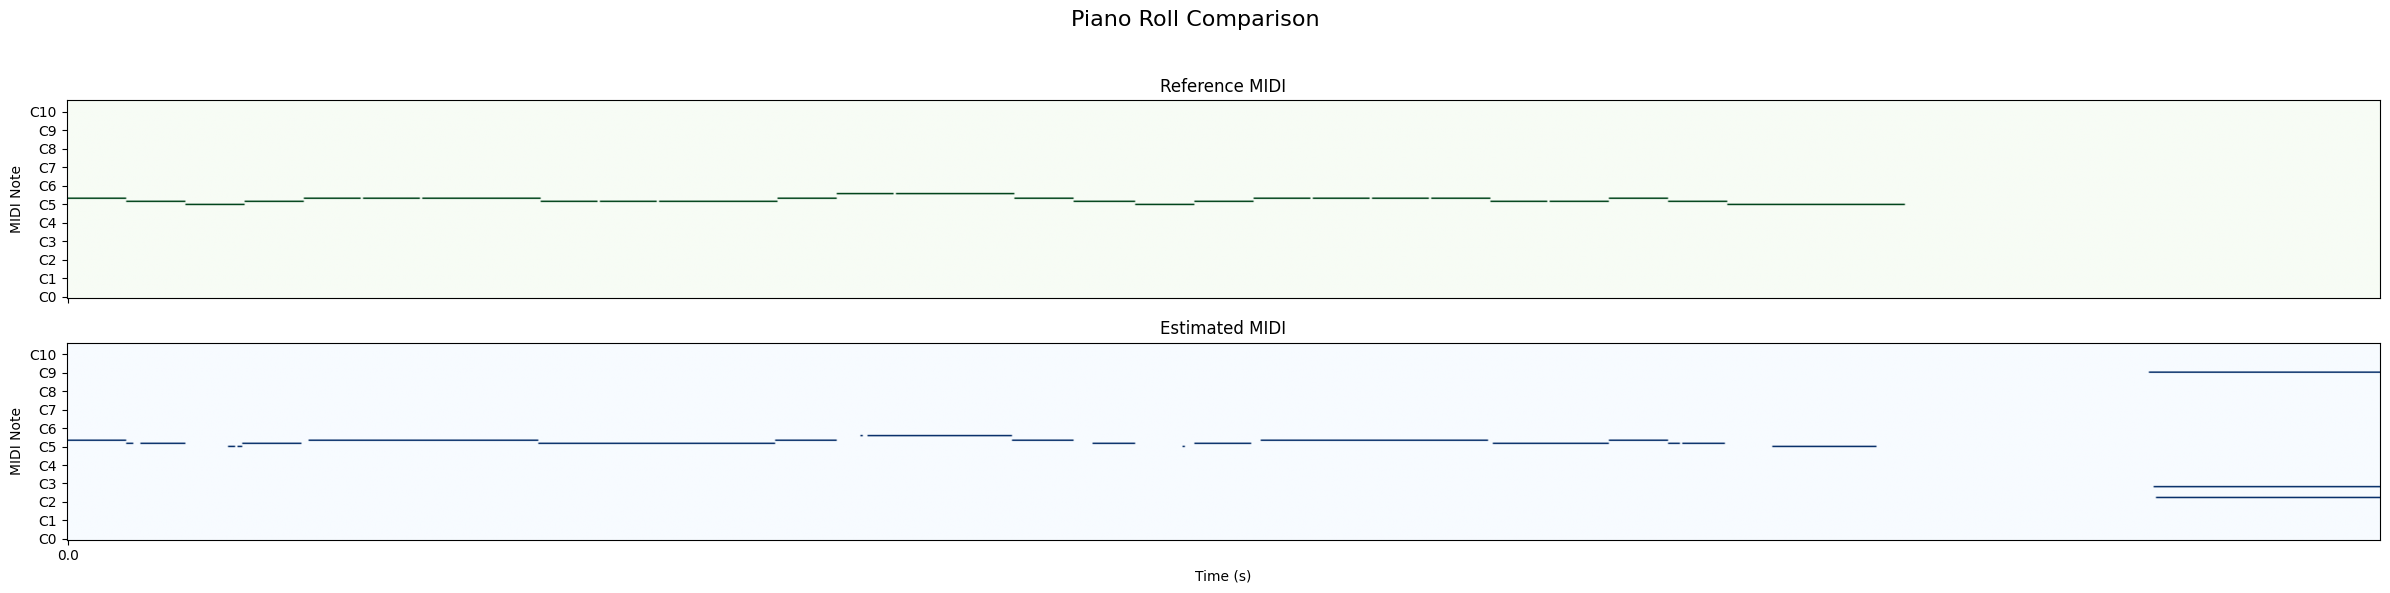

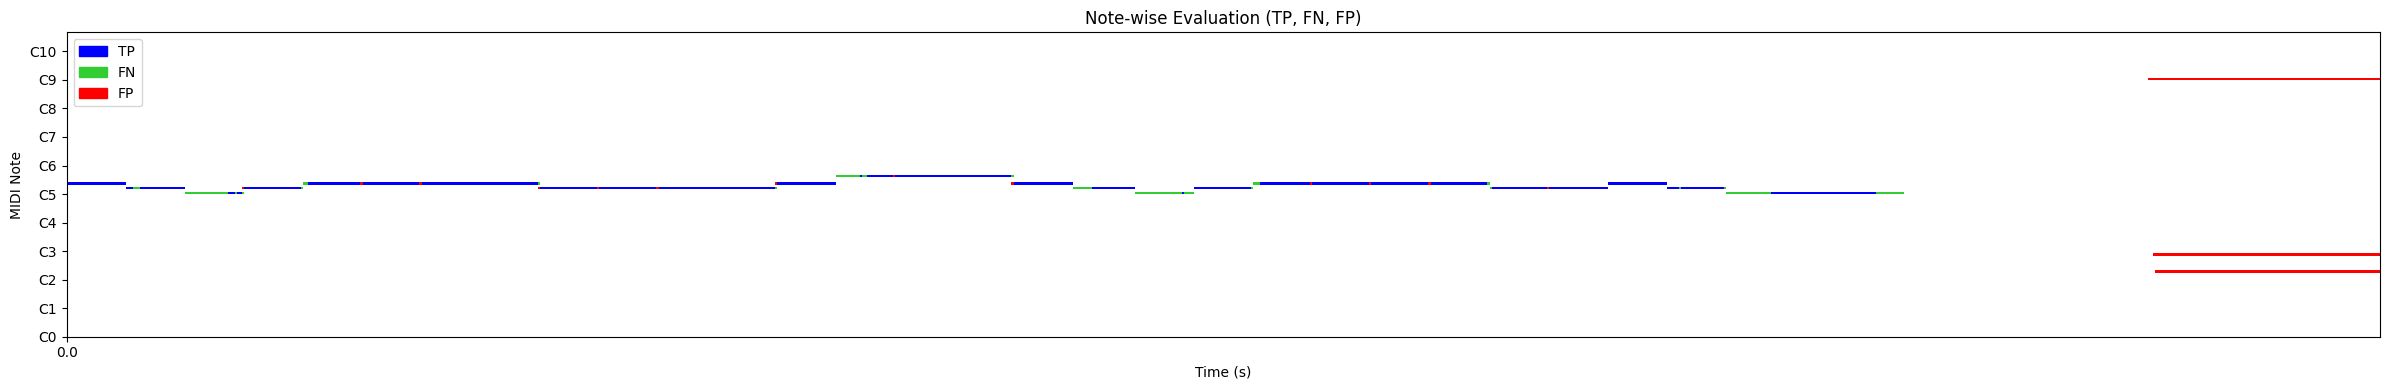

In [292]:
# plot_full_comparison(m1_bin[:,:n], m2_bin[:,:n], TP[:,:n], FN[:,:n], FP[:,:n], fs)
m = 0
n = 10000
plot_piano_rolls(m1_bin[:,m:n], m2_bin[:,m:n], fs=1000)
plot_notewise_eval(TP[:,m:n], FN[:,m:n], FP[:,m:n], fs=1000)

In [266]:
import pretty_midi
import mir_eval
import numpy as np

def midi_to_mir_eval_format(pm):
    intervals = []
    pitches = []
    for inst in pm.instruments:
        for n in inst.notes:
            intervals.append([n.start, n.end])
            pitches.append(n.pitch)
    return np.array(intervals), np.array(pitches)

# Load MIDI
ref = pretty_midi.PrettyMIDI(reff)
est = pretty_midi.PrettyMIDI(estt)

# ref = ref[:, :n]
# est = est[:,:n]
# Convert to mir_eval-compatible inputs
ref_intervals, ref_pitches = midi_to_mir_eval_format(ref)
est_intervals, est_pitches = midi_to_mir_eval_format(est)

# Onset-only F1 (disable offset matching)
results_onset = mir_eval.transcription.evaluate(
    ref_intervals, ref_pitches,
    est_intervals, est_pitches,
    onset_tolerance=0.05,     # 50ms tolerance
    offset_ratio=None         # <--- disable offset matching
)

# Onset + Offset F1
results_onoff = mir_eval.transcription.evaluate(
    ref_intervals, ref_pitches,
    est_intervals, est_pitches,
    onset_tolerance=0.05,
    offset_ratio=0.2          # 20% offset match required
)

# Show results
print(f"Onset-only F1         : {results_onset['Onset_F-measure']:.4f}")
print(f"Onset+Offset F1       : {results_onoff['F-measure']:.4f}")
print(f"Onset-only Precision  : {results_onset['Onset_Precision']:.4f}")
print(f"Onset-only Recall     : {results_onset['Onset_Recall']:.4f}")


Onset-only F1         : 0.7874
Onset+Offset F1       : 0.6457
Onset-only Precision  : 0.6494
Onset-only Recall     : 1.0000
